# Global Diferential Privacy Assessement: Univariate case

In this notebook, we will explore the univariate case of the Global Differential Privacy using a dataset from use case 2.1. After running this notebook, you will be able to:
- Understand the concept of Global Differential Privacy.
- Apply Global Differential Privacy to a univariate dataset.

We also run a monte carl simulation to validate the GDP implementation.

## Import data and visualise

The data are imported and only available via 'pipelines' i.e. automations made by a user. As such GDP operates on the user pipeline and not directly on the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
! pip install wget --quiet 
import wget


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)
clean_data = data[~np.isnan(data)]
print(f"\n\tClean data: {clean_data}")

100% [..........................................................] 39886 / 39886
Original file downloaded.

	Clean data: [178.   155.   169.   157.   171.   166.   167.   175.   165.   160.
 160.   156.   155.   162.   168.   165.   163.   164.   172.   180.
 160.   160.   160.   174.   162.   164.   173.   168.   160.   160.
 170.   185.   177.   177.   182.   175.   165.   175.   180.   165.
  58.   185.     1.65 167.   153.   174.   173.   175.   167.   170.
 178.   185.   172.   157.   172.   157.   171.   163.  ]


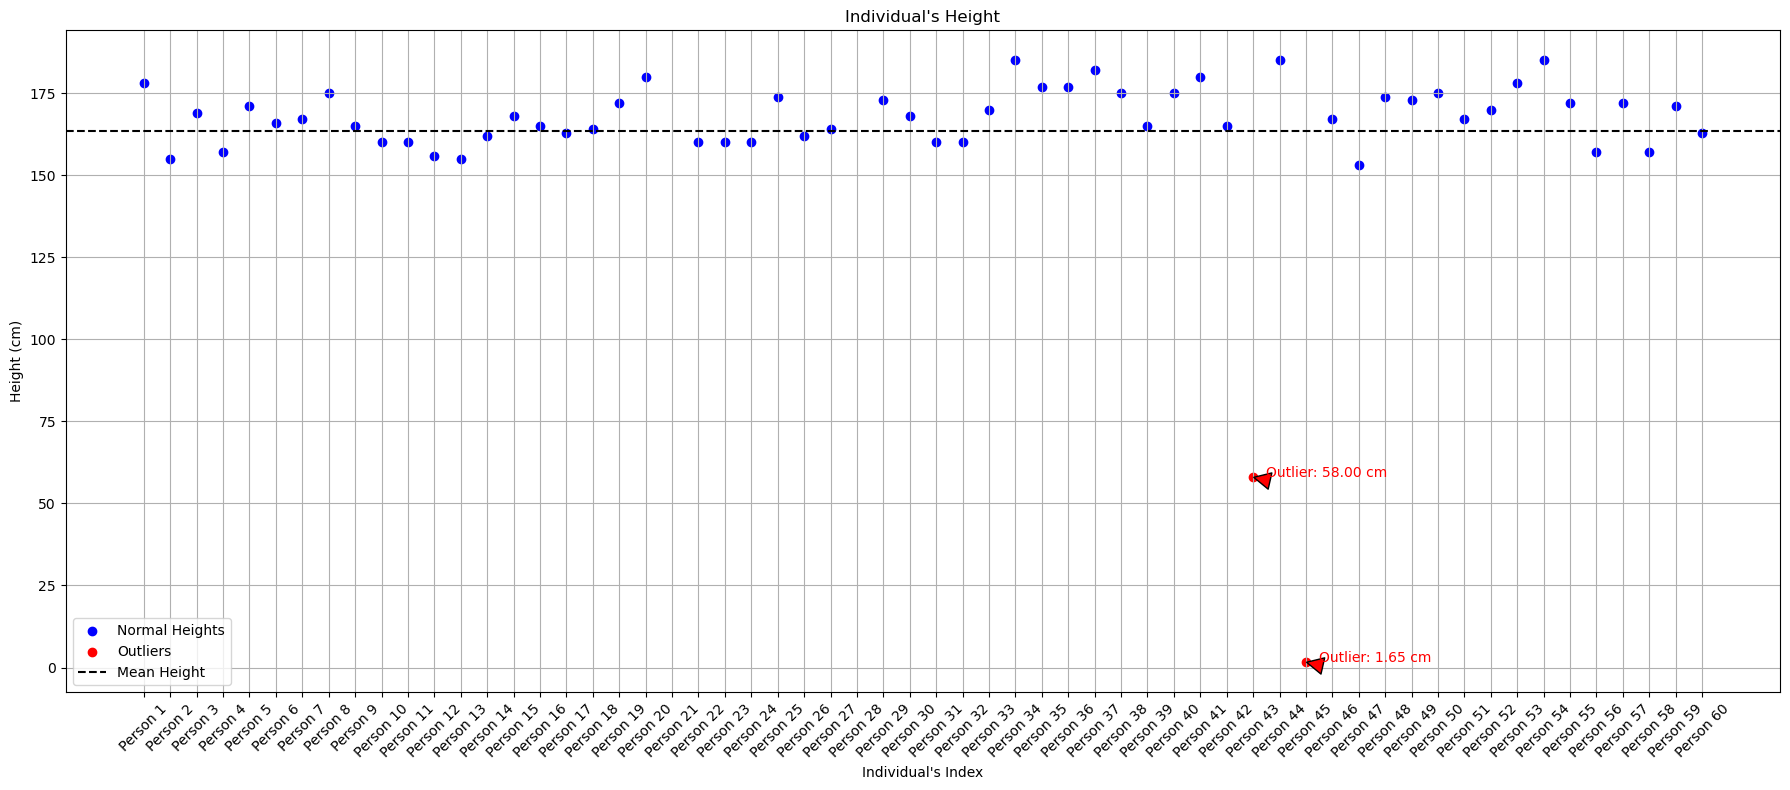

In [3]:
data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)

clean_data = data[~np.isnan(data)]
q1 = np.percentile(clean_data, 25)
q3 = np.percentile(clean_data, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
plt.figure(figsize=(18, 8))
normal_indices = [i for i in range(len(data)) if i not in outlier_indices and i not in outlier_indices]
plt.scatter(normal_indices, data[normal_indices], color='blue', label='Normal Heights')
plt.scatter(outlier_indices, data[outlier_indices], color='red', label='Outliers')

for outlier_idx in outlier_indices:
    plt.annotate(f'Outlier: {data[outlier_idx][0]:.2f} cm',
                xy=(outlier_idx, data[outlier_idx]),
                xytext=(outlier_idx+0.5, data[outlier_idx]),
                arrowprops=dict(facecolor='red', shrink=0.05),
                color='red')
plt.axhline(np.nanmean(data), color='black', linestyle='--', label='Mean Height')
plt.title("Individual's Height")
plt.xlabel("Individual's Index")
plt.xticks(range(len(data)), [f"Person {i + 1}" for i in range(len(data))], rotation=45)
plt.ylabel("Height (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Global Differential Privacy

Global Differential Privacy (DP) is a mathematical framework that provides strong, quantifiable privacy guarantees when analyzing and sharing data. Its core idea is to ensure that the inclusion or exclusion of a single individual’s data does not significantly affect the output of an analysis, thereby limiting what can be inferred about any one person. This limits the ability of an attacker to infer whether someone participated in the dataset, even if they possess additional background information. To achieve this, DP algorithms inject calibrated random noise into outputs.

## User Output

A data user has an analysis pipeline that s run on the data. The output of such pipeline is then made differentially private.

Here, the pipeline simply consists in computing the mean.


In [4]:
def user_output(clean_data):

    pipeline_output = np.mean(clean_data)
    return pipeline_output

In [5]:
pipeline_output = user_output(clean_data)
print("the true mean is: ", user_output(clean_data))

the true mean is:  163.42499999999998


## GDP algorithm

The procedure take the user pipeline and data and applies a leave one out (loo) resampling to the data to obtain the influence function, i.e. the output of the user pipeline for each loo resample are compared to the user output. The maximum of that gives the lower bound of the noise to be applied (i.e. it provides the information on the observation which has the largest influence).  



In [6]:
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
print(f"\n\tall loo data: {loo_data}")


	all loo data: [[155. 169. 157. ... 157. 171. 163.]
 [178. 169. 157. ... 157. 171. 163.]
 [178. 155. 157. ... 157. 171. 163.]
 ...
 [178. 155. 169. ... 172. 171. 163.]
 [178. 155. 169. ... 172. 157. 163.]
 [178. 155. 169. ... 172. 157. 171.]]


In [7]:
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"\n\tall loo mean values: {loo_output}")
print(f"\n\tloo for outliers: {loo_output[outlier_indices]}")


	all loo mean values: [163.16929825 163.57280702 163.32719298 163.5377193  163.29210526
 163.37982456 163.3622807  163.22192982 163.39736842 163.48508772
 163.48508772 163.55526316 163.57280702 163.45       163.34473684
 163.39736842 163.43245614 163.41491228 163.2745614  163.13421053
 163.48508772 163.48508772 163.48508772 163.23947368 163.45
 163.41491228 163.25701754 163.34473684 163.48508772 163.48508772
 163.30964912 163.04649123 163.18684211 163.18684211 163.09912281
 163.22192982 163.39736842 163.22192982 163.13421053 163.39736842
 165.2745614  163.04649123 166.26315789 163.3622807  163.60789474
 163.23947368 163.25701754 163.22192982 163.3622807  163.30964912
 163.16929825 163.04649123 163.2745614  163.5377193  163.2745614
 163.5377193  163.29210526 163.43245614]

	loo for outliers: [166.26315789 163.60789474]


In [8]:
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\n\tsensitivity: {sensitivity}")


	sensitivity: 2.8381578947368666


## Sampling from a noise distribution

Of course the noise value has to come from somewhere. Here we choose a Laplace distribution centred on 0 with the scale equal to variance of loo means, ie reflecting how much change we have due to single observations.

In [9]:
loo_scale = np.std(loo_output)
print(f"\n\tnoise scale: {loo_scale}")

while True:
    noise_batch = np.random.normal(loc=0.0, scale=loo_scale, size=1000)
    valid = noise_batch[np.abs(noise_batch) >= sensitivity]
    if valid.size > 0:
        noise = valid[0]
        break
        
print(f"\n\tnoise: {noise}")
gdp_resut = pipeline_output + noise;
print(f"\n\tgdp result: {gdp_resut}")


	noise scale: 0.47422918086144344

	noise: -3.2804784563121587

	gdp result: 160.14452154368783


## Validation

Here we use monte carlo simulations to show that the results are differentially private.
Since GDP is defined by the influence of a single observation, we resample the data with replacement (bootstrap) to generate 1000 replicats. For each replicats, the user is asking for leave one out means, which will allow to reconstruct the data if not noisy (see notebook 1). Here, for each of those outpouts, noise is added, and we show that the user cannot reconstruct the data nor even identify outliers.

we start by defining the object dp, which simply add noise as explained above, and reuse this for the user outputs

In [10]:
sample_data = np.random.normal(loc=168, scale=10, size=len(clean_data) - 1)
sample_data = np.append(sample_data, 58)
print(f"Sample data:\n\n {sample_data}")

Sample data:

 [150.28599455 175.0482528  173.91313616 175.14527567 156.45468669
 180.88474175 170.90218298 171.40183028 162.00309443 158.77032656
 151.15889455 175.38118811 159.38917621 165.26781643 158.20485149
 164.97785943 167.04674267 190.07224485 176.21146619 169.30037955
 178.94451505 174.06902366 167.78709645 172.13331836 175.32932975
 177.78630171 161.13294738 172.69475804 164.46457473 154.58047455
 172.6001235  170.05380399 170.37139089 185.39074616 182.58349753
 170.34488418 162.00382596 182.4425931  173.96023333 170.76475904
 183.81347452 164.36770836 183.02555556 167.87592348 164.67130312
 163.07408352 169.00788544 185.23725747 154.03743982 157.36332468
 161.26449256 163.43378377 166.2075253  177.55694374 188.76254938
 176.71485212 148.97145366  58.        ]


In [11]:
def dp(clean_data,pipeline_output):


    loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_scale = np.std(loo_output)
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    while True:
        noise_batch = np.random.normal(loc=0.0, scale=loo_scale, size=1000)
        valid = noise_batch[np.abs(noise_batch) >= sensitivity]
        if valid.size > 0:
            noise = valid[0]
            break

    return pipeline_output + noise

In [ ]:

def dp(clean_data, pipeline_output):
    loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_scale = np.std(loo_output)
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    
    noise = gen_noise(loo_scale, sensitivity)
    
    return pipeline_output + noise

@njit
def gen_noise(loo_scale, sensitivity):
    while True:
        noise_batch = np.random.normal(loc=0.0, scale=loo_scale, size=1000)
        for noise in noise_batch:
            if np.abs(noise) >= sensitivity:
                return noise


@njit
def sample_data_(mean, std, size, outlier):
    sample = np.random.normal(loc=mean, scale=std, size=size - 1)
    result = np.empty(size)
    result[:size - 1] = sample
    result[-1] = outlier
    return result


n_replicates = 1000
noisy_results = []

n = len(clean_data)
outlier = 58
c = 0

start = time.time()
for _ in range(n_replicates):
    sample_data = sample_data_(mean=170, std=10, size=n, outlier=outlier)
    
    loo_output = np.array([user_output(np.delete(sample_data, i)) for i in range(n)])

    noisy_loo_outputs = [dp(sample_data, output) for output in loo_output]
    noisy_results.append(noisy_loo_outputs)

    ########### Reconstruction part
    recons = np.linalg.solve(np.ones((n, n)) - np.eye(n), (n-1) * noisy_loo_outputs)
    print(f"Original data; {sample_data[-1]}, Recreated data: {recons}")
    c += 1 if sample_data[-1] == recons else 0
    
print(f"{(c / n_replicates) *100}% reconstructed successfully.")
print("Generated", n_replicates, "bootstrap replicates and applied DP to leave-one-out outputs.")
print("Time taken: ", time.time() - start)

In [ ]:
plt.figure(figsize=(18, 8))
plt.boxplot(noisy_results, labels=[f"Person {i+1}" for i in range(n)], patch_artist=True)
plt.plot(range(1, n+1), clean_data, 'ro', label="True Value") 
plt.title("Reconstructed Outlier Distribution from noisy LOO")
plt.xlabel("Individual Index")
indices = np.arange(len(clean_data))
plt.xticks(indices, [f"P{i + 1}" for i in indices], rotation=45)
plt.ylabel("Reconstructed Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()